In [6]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

# Dataset

In [490]:
image_folder = 'test_set'
dataset = {
    'close_red': ['buoy855.jpg', 'buoy763.jpg'],
    'close_yellow': ['buoy863.jpg'],
    '2_buoys': ['buoy839.jpg', 'buoy835.jpg', 'buoy795.jpg', 
                'buoy743.jpg', 'buoy723.jpg', 'buoy611.jpg', 
                'buoy586.jpg', 'buoy494.jpg'],
    '3_buoys': ['buoy827.jpg', 'buoy819.jpg', 'buoy817.jpg', 
                'buoy711.jpg', 'buoy699.jpg', 'buoy695.jpg',
                'buoy463.jpg', 'buoy443.jpg']
}

The red buoy looks like this.

This image is: <class 'numpy.ndarray'> with dimesions: (432, 768, 3)


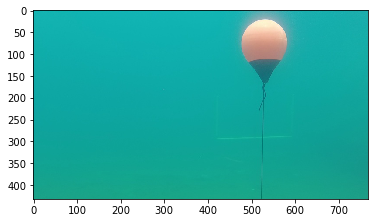

In [8]:
image_red = mpimg.imread(os.path.join(image_folder, dataset['close_red'][0]))
print('This image is:', type(image), 'with dimesions:', image.shape)
plt.imshow(image) 

# Hough algorithm test

In [374]:
# parameters for this test
parameters = {
    'gaussian_kernel': 5,
    'canny': {
        'low_threshold': 20,
        'high_threshold': 150
    }
}

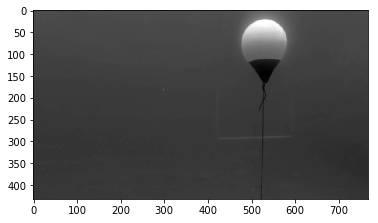

In [375]:
# convert to gray
gray = cv2.cvtColor(image_red, cv2.COLOR_RGB2GRAY)
# gaussian blur
blur = cv2.GaussianBlur(gray, 
                        (parameters['gaussian_kernel'], parameters['gaussian_kernel']), 0)
plt.imshow(blur, cmap='gray')

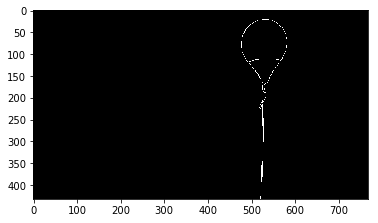

In [369]:
# edge detection
edges = cv2.Canny(blur, parameters['canny']['low_threshold'], parameters['canny']['high_threshold'])
plt.imshow(edges, cmap='gray')

In [370]:
def draw_circles(image, circles):
    output = np.copy(image)
    if circles is not None:
        # convert the (x, y) coordinates and radius of the circles to integers
        circles = np.round(circles[0, :]).astype("int")
 
        # loop over the (x, y) coordinates and radius of the circles
        for (x, y, r) in circles:
            cv2.circle(output, (x, y), r, (0, 255, 0), 4)
    else:
        print("No buoy detected :(")
    return output

In [392]:
parameters['hough'] = {
        'dp': 1, # image res / accumulator res
        'minDist': 10, # minimum distance between centers of detected circles
        'param1': 150, # higher threshold of canny
        'param2': 30, # accumulator threshold for the circle centers at the detection stage
        'minRadius': 20,
        'maxRadius': 50
    }

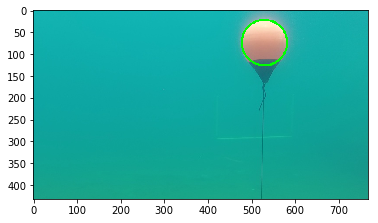

In [393]:
# hough circles
circles = cv2.HoughCircles(edges,
                          cv2.HOUGH_GRADIENT,
                          parameters['hough']['dp'],
                          parameters['hough']['minDist'],
                          parameters['hough']['param1'],
                          parameters['hough']['param2'],
                          parameters['hough']['minRadius'],
                          parameters['hough']['maxRadius'] 
                          )
final = draw_circles(image, circles)
plt.imshow(final)

# Ellipse fitting test

### Find contours

In [454]:
parameters['contours'] = {
    'retrival_mode': cv2.RETR_LIST,
    'approx_method': cv2.CHAIN_APPROX_NONE,
}

In [265]:
im2, contours, hierarchy = cv2.findContours(edges, 
                                            parameters['contours']['retrival_mode'],
                                            parameters['contours']['approx_method'],
                                           )

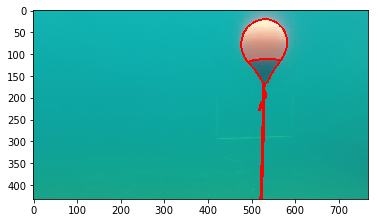

In [431]:
def draw_contours(image, contours, binary=False):
    if binary:
        output = np.zeros((image.shape[0], image.shape[1]), dtype='uint8')
        cv2.drawContours(output, contours, -1, 254, 3)
    else:
        output = np.copy(image)
        cv2.drawContours(output, contours, -1, (254,0,0), 3)
        
    return output

contour_image = draw_contours(image, contours, False)
plt.imshow(contour_image)


### Fit ellipse

In [432]:
ellipses = []
for c in contours:
    ellipses.append(cv2.fitEllipse(c))

In [433]:
ellipses

[((527.9508056640625, 204.84152221679688),
  (3.5341055393218994, 11.183024406433105),
  21.015893936157227),
 ((530.2772827148438, 193.30520629882812),
  (3.1189358234405518, 9.8941068649292),
  177.72239685058594),
 ((528.1832885742188, 193.5), (2.928133487701416, 16.953859329223633), 0.0),
 ((529.8649291992188, 185.00083923339844),
  (6.946172714233398, 31.280685424804688),
  173.58518981933594),
 ((530.0008544921875, 168.1572265625),
  (3.9944279193878174, 6.458707809448242),
  119.26146697998047),
 ((530.5558471679688, 132.87045288085938),
  (55.23486328125, 65.86554718017578),
  83.59539031982422),
 ((520.7265014648438, 197.67955017089844),
  (116.32492065429688, 379.7445983886719),
  5.248987674713135)]

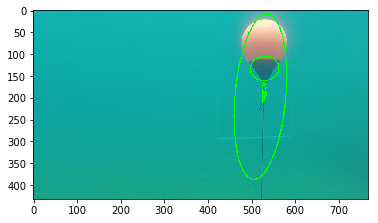

In [434]:
def draw_ellipse(image, ellipses):
    output = np.copy(image)
    for ellipse in ellipses:
        cv2.ellipse(output, ellipse, (0,255,0), 2)
    return output
    
ellipses_image = draw_ellipse(image, ellipses)
plt.imshow(ellipses_image)

Fitellipse is fitting ellipses around everything. Not good. Trying other approaches

### Hough circle on contours

In [446]:
parameters['hough'] = {
        'dp': 1, # image res / accumulator res
        'minDist': 10, # minimum distance between centers of detected circles
        'param1': 150, # higher threshold of canny
        'param2': 30, # accumulator threshold for the circle centers at the detection stage
        'minRadius': 20,
        'maxRadius': 50
    }

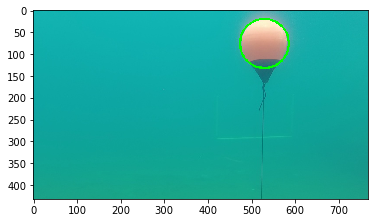

In [448]:
# hough circles
contour_image = draw_contours(image, contours, True)
circles = cv2.HoughCircles(contour_image,
                          cv2.HOUGH_GRADIENT,
                          parameters['hough']['dp'],
                          parameters['hough']['minDist'],
                          parameters['hough']['param1'],
                          parameters['hough']['param2'],
                          parameters['hough']['minRadius'],
                          parameters['hough']['maxRadius'] 
                          )
final = draw_circles(image, circles)
plt.imshow(final)

## Function for everything done so far

In [501]:
parameters = {
    'gaussian_kernel': 5,
    'canny': {
        'low_threshold': 20,
        'high_threshold': 150
    },
    'contours': {
        'retrival_mode': cv2.RETR_LIST,
        'approx_method': cv2.CHAIN_APPROX_NONE,
    },
    'hough': {
        'dp': 1, # image res / accumulator res
        'minDist': 10, # minimum distance between centers of detected circles
        'param1': 150, # higher threshold of canny
        'param2': 30, # accumulator threshold for the circle centers at the detection stage
        'minRadius': 20,
        'maxRadius': 50
    },
}

In [502]:
def find_buoy(image, parameters, debug=False, useContours=False):
    # convert to gray
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # gaussian blur
    blur = cv2.GaussianBlur(gray, 
                        (parameters['gaussian_kernel'], parameters['gaussian_kernel']), 0)
    # edge detection
    edges = cv2.Canny(blur, parameters['canny']['low_threshold'], parameters['canny']['high_threshold'])    
    if debug:
        print("edges")
        plt.imshow(edges, cmap='gray'); plt.show()
        
    # contours
    if useContours:
        im2, contours, hierarchy = cv2.findContours(edges, 
                                                    parameters['contours']['retrival_mode'],
                                                    parameters['contours']['approx_method'],
                                                   )
        contour_image = draw_contours(image, contours, True)
        if debug:
            print("contours")
            plt.imshow(contour_image, cmap='gray'); plt.show()
    else:
        contour_image = edges
    circles = cv2.HoughCircles(contour_image,
                          cv2.HOUGH_GRADIENT,
                          parameters['hough']['dp'],
                          parameters['hough']['minDist'],
                          parameters['hough']['param1'],
                          parameters['hough']['param2'],
                          parameters['hough']['minRadius'],
                          parameters['hough']['maxRadius'] 
                          )
    final = draw_circles(image, circles)
        
    return final

CPU times: user 56 ms, sys: 0 ns, total: 56 ms
Wall time: 16.4 ms


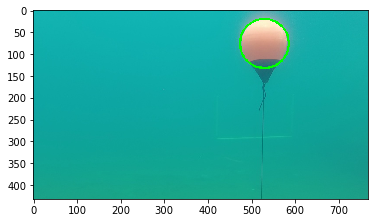

CPU times: user 24 ms, sys: 24 ms, total: 48 ms
Wall time: 9.81 ms


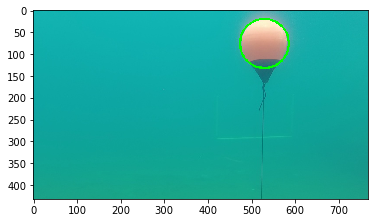

In [503]:
image = mpimg.imread(os.path.join(image_folder, dataset['close_red'][0]))
%time buoy_found = find_buoy(image, parameters, useContours=True) 
plt.imshow(buoy_found); plt.show()
%time find_buoy(image, parameters, useContours=False) 
plt.imshow(buoy_found); plt.show()

Contours are not too expensive

## Test with different images

test_set/buoy839.jpg
edges


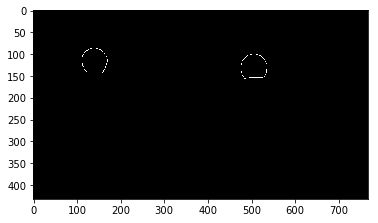

contours


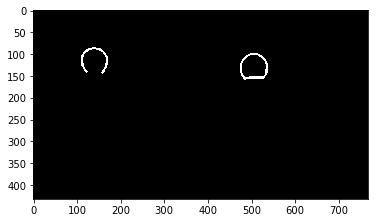

No buoy detected :(


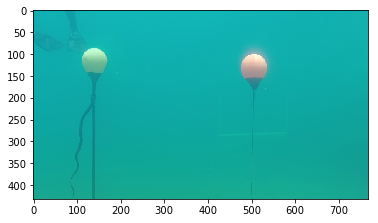

test_set/buoy835.jpg
edges


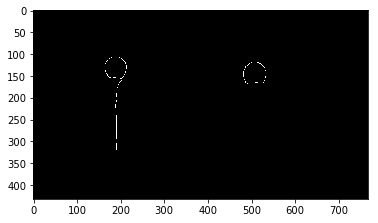

contours


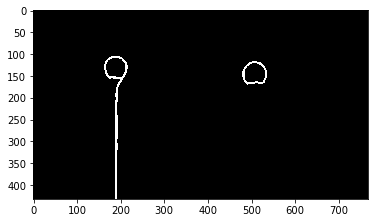

No buoy detected :(


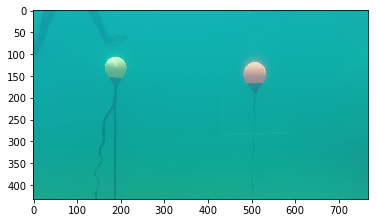

test_set/buoy795.jpg
edges


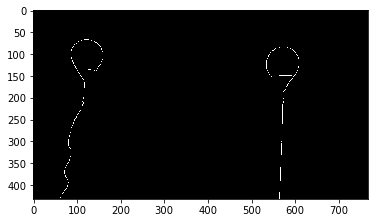

contours


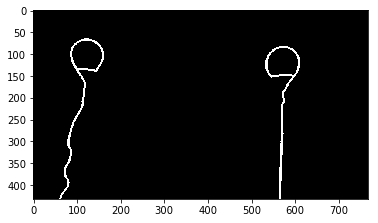

No buoy detected :(


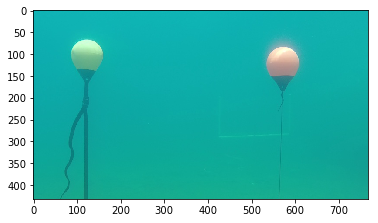

test_set/buoy743.jpg
edges


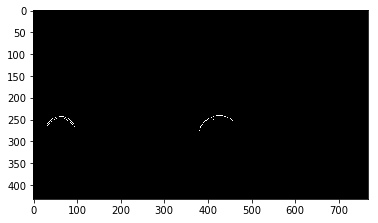

contours


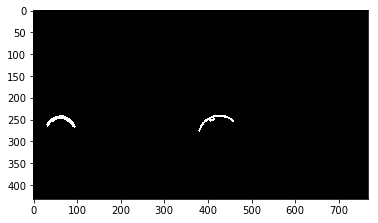

No buoy detected :(


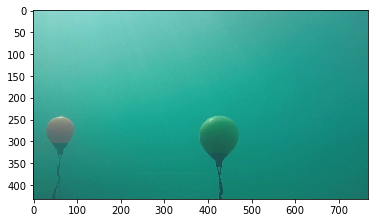

test_set/buoy723.jpg
edges


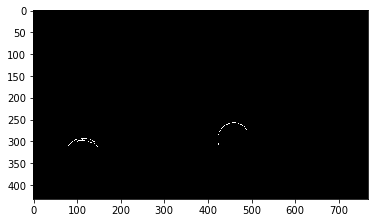

contours


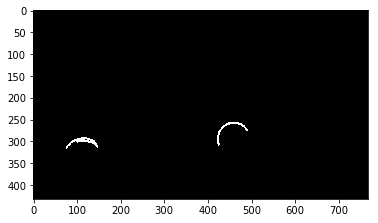

No buoy detected :(


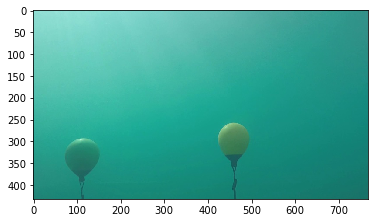

test_set/buoy611.jpg
edges


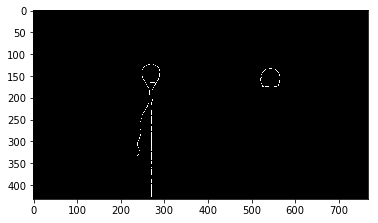

contours


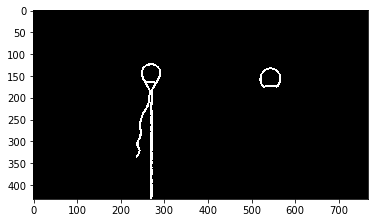

No buoy detected :(


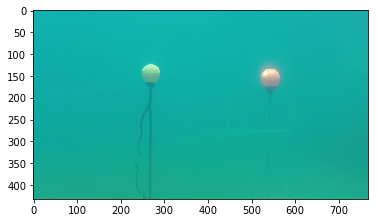

test_set/buoy586.jpg
edges


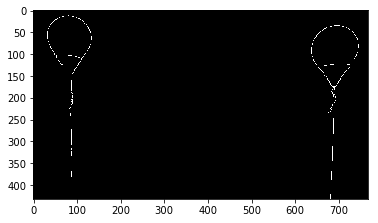

contours


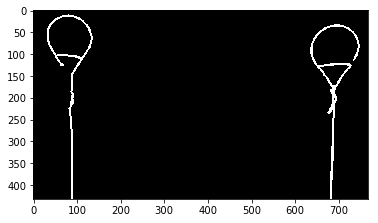

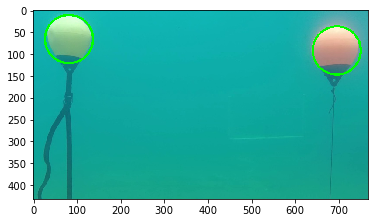

test_set/buoy494.jpg
edges


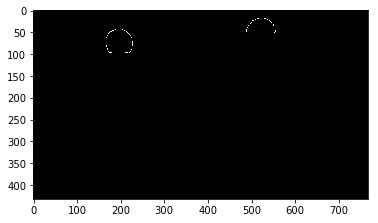

contours


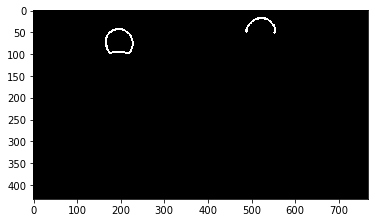

No buoy detected :(


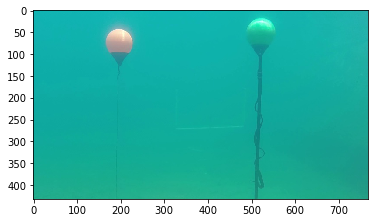

test_set/buoy827.jpg
edges


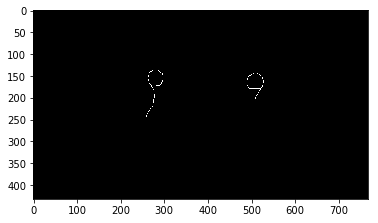

contours


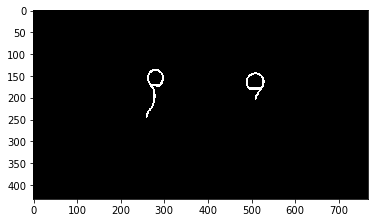

No buoy detected :(


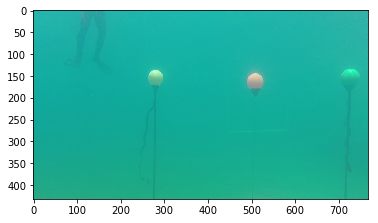

test_set/buoy819.jpg
edges


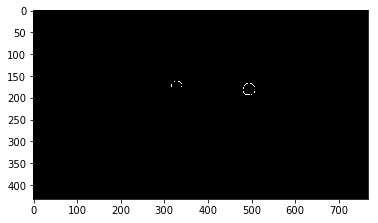

contours


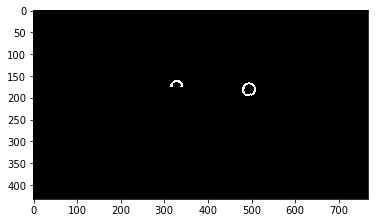

No buoy detected :(


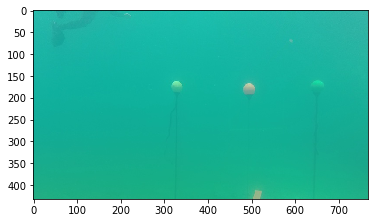

test_set/buoy817.jpg
edges


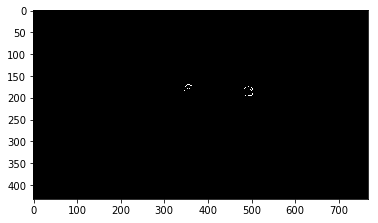

contours


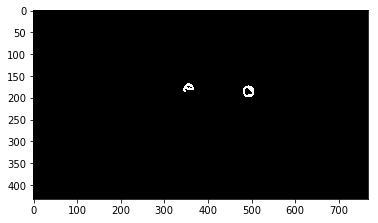

No buoy detected :(


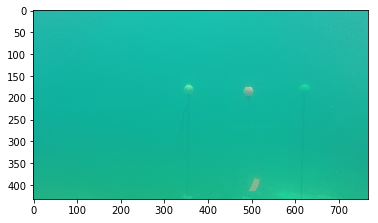

test_set/buoy711.jpg
edges


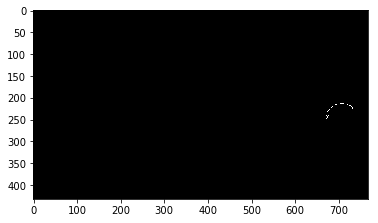

contours


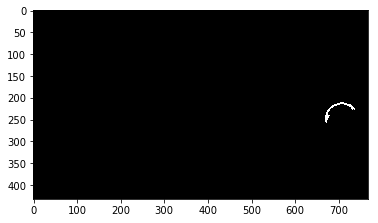

No buoy detected :(


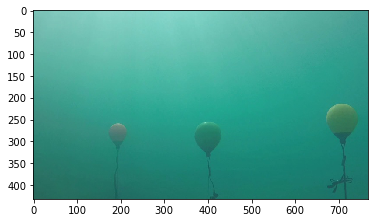

test_set/buoy699.jpg
edges


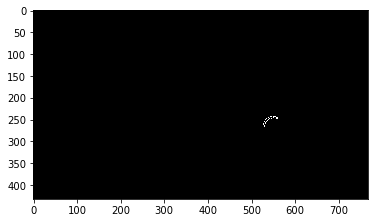

contours


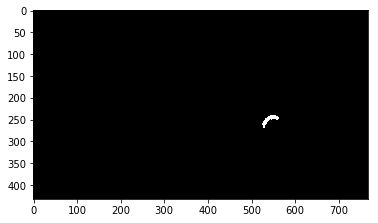

No buoy detected :(


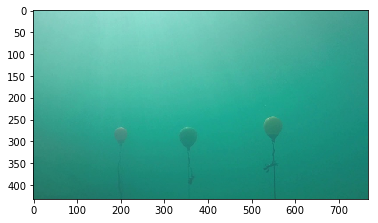

test_set/buoy695.jpg
edges


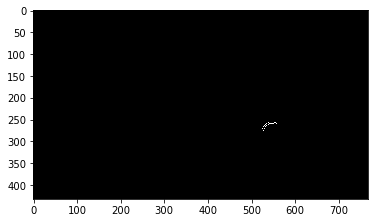

contours


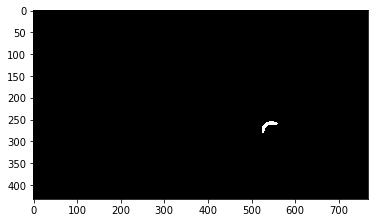

No buoy detected :(


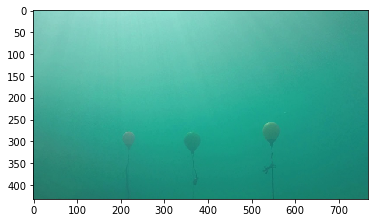

test_set/buoy463.jpg
edges


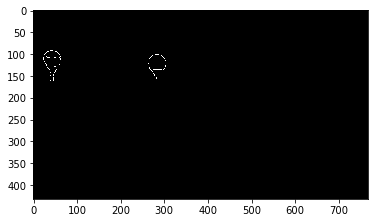

contours


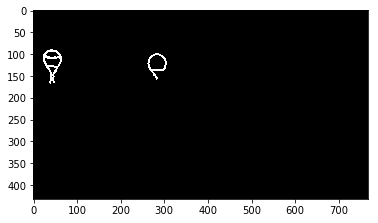

No buoy detected :(


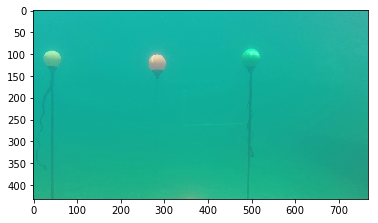

test_set/buoy443.jpg
edges


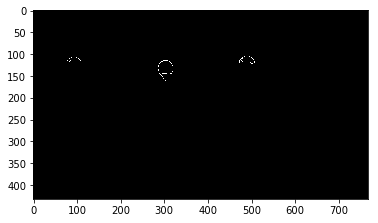

contours


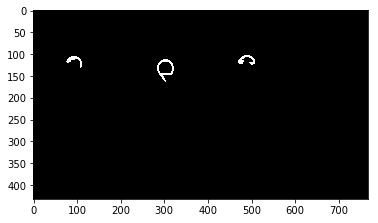

No buoy detected :(


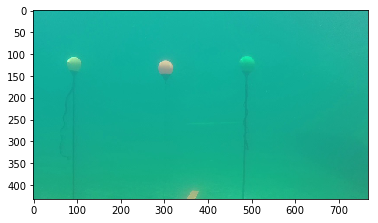

test_set/buoy863.jpg
edges


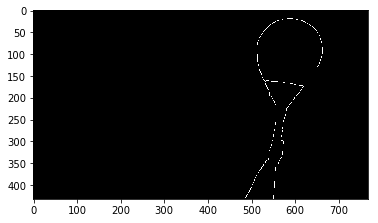

contours


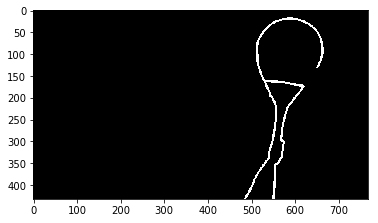

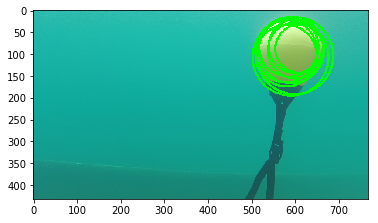

test_set/buoy855.jpg
edges


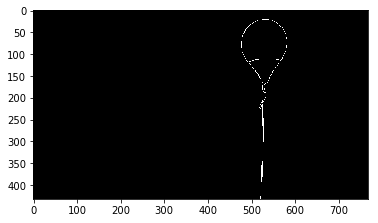

contours


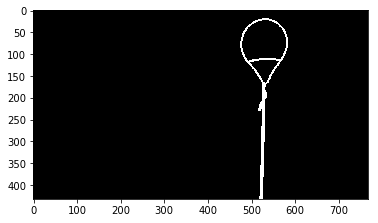

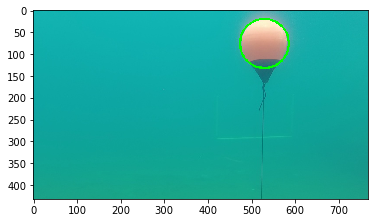

test_set/buoy763.jpg
edges


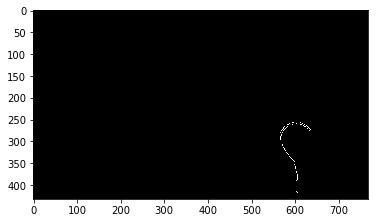

contours


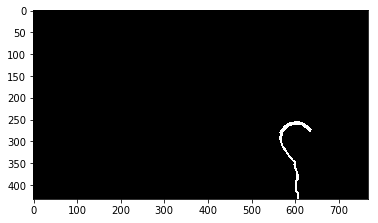

No buoy detected :(


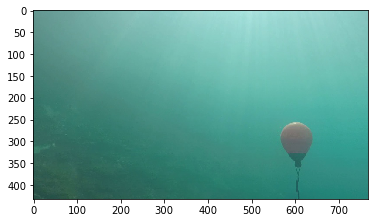

In [505]:
for _, image_list in dataset.items():
    for imageUrl in image_list:
        url = os.path.join(image_folder, imageUrl)
        print(url)
        image = mpimg.imread(url)
        buoy_found = find_buoy(image, parameters, debug=True, useContours=True) 
        plt.imshow(buoy_found); plt.show()


 Pretty bad results :(